In [1]:
# horse-or-human classification model with CNN
# train : 1027 images [horse(500) + human(527)] , 300*300 pixels
# validation : 256 images [horse(128) + human(128)] , 300*300 pixels

In [2]:
# CPU 버전에서 실습 할것
# Colab 사용시 소스에서 경로명 수정 필요  : 'tmp/xxx'  ---> '/tmp/xxx'

In [3]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.17.0


In [4]:
# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
#     -O /tmp/horse-or-human.zip

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
#     -O /tmp/validation-horse-or-human.zip

In [5]:
# horse-or-human 데이터셋 다운로드 , Windows용
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')
urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')

('validation-horse-or-human.zip', <http.client.HTTPMessage at 0x20e23f98850>)

In [6]:
# 압축해제
local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

train_dir = 'tmp/horse-or-human'
validation_dir = 'tmp/validation-horse-or-human'

In [7]:
# 이미지 데이터 경로 설정
import os
# Directory with our training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
# print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
# print(train_human_names[:10])

validation_horse_names = os.listdir(validation_horse_dir)
# print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)

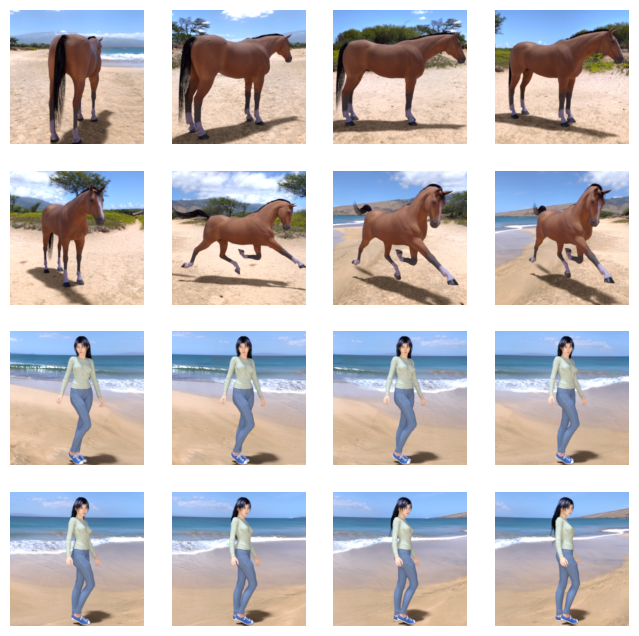

In [8]:
# 데이터 시각화 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 15  # 시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

# print(next_horse_pix)
# print(next_human_pix)

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### CNN Model 구현

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

### 데이터 전처리 : 이미지 증강(Image Augmentation)

In [12]:
! pip install Augmentor
import Augmentor

## 증강 시킬 이미지 폴더 경로
img = Augmentor.Pipeline("augmentation_test/")

## 좌우 반전
img.flip_left_right(probability=1.0) 

## 상하 반전
img.flip_top_bottom(probability=1.0)

## 왜곡
img.random_distortion(probability=1, grid_width=10, grid_height=10, magnitude=8)

## 증강 이미지 수
img.sample(10)

Initialised with 1 image(s) found.
Output directory set to augmentation_test/output.

Processing <PIL.Image.Image image mode=RGBA size=257x252 at 0x20E26887460>: 100%|████████████| 10/10 [00:00<00:00, 118.02 Samples/s]


In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255.)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,          
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        #save_to_dir='tmp/saved_train_image')

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        #save_to_dir='tmp/saved_val_image')  # 학습시 변환 생성된 이미지를 저장한다

print(train_generator)  # DirectoryIterator object , 실제 사용 시점(학습시)에 데이터 생성

# fit 호출시 1 epoch 마다 train 이미지 1027개 생성  : 15 epochs 일 경우 총 15*1027 증강 이미지 생성
# fit 호출시 1 epoch 마다 validation 이미지 256개 생성  : 15 epochs 일 경우 총 15*256 증강 이미지 생성

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### 학습

In [14]:
import os 

# NVIDIA가 아닌 GPU와 함께 사용시(GPU가 2개 이상일 경우) OOM 오류 발생 

# OP_REQUIRES failed at pooling_ops_common.cc:455 : Resource exhausted: OOM when allocating tensor
# with shape[128,16,298,298] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

# GPU를 아예 못 보게 하려면: 
# os.environ["CUDA_VISIBLE_DEVICES"]=''      # 성공

# 두번째 실행시 반드시 shudown하여 초기화하고 다시 실행한다(Restart는 오류남)

# GPU 0만 보게 하려면: 
#os.environ["CUDA_VISIBLE_DEVICES"]='0'    --> OOM오류발생

# GPU 1만 보게 하려면: 
# os.environ["CUDA_VISIBLE_DEVICES"]='1'   --> OOM오류발생

# GPU 0과 1을 보게 하려면: 
#os.environ["CUDA_VISIBLE_DEVICES"]='0,1'  --> OOM오류발생

# https://datamasters.co.kr/33


In [16]:
# CPU버전 : 약 8~9분 소요, GPU : 1.5분 
history = model.fit(
      train_generator,      # x
      steps_per_epoch=8,    # 1027/128  , train image numbers/train batch_size
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      #validation_steps=8,   # 256/32  , validation image numbers/validation batch_size
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 951ms/step - accuracy: 0.6738 - loss: 0.6507 - val_accuracy: 0.8555 - val_loss: 0.6128
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.6953 - loss: 0.6645 - val_accuracy: 0.5039 - val_loss: 0.6618
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7610 - loss: 0.6120 - val_accuracy: 0.5078 - val_loss: 0.6110
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.7656 - loss: 0.6024 - val_accuracy: 0.5000 - val_loss: 0.6172
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7250 - loss: 0.8085 - val_accuracy: 0.5820 - val_loss: 0.5903
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.8047 - loss: 0.5643 - val_accuracy: 0.5664 - val_loss: 0.5988
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8052 - loss: 0.4797 - val_accuracy: 0.5664 - val_loss: 0.9594
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.8750 - loss: 0.3107 - val_accuracy: 0.6797 - val_loss: 0.78

### 학습 결과 시각화

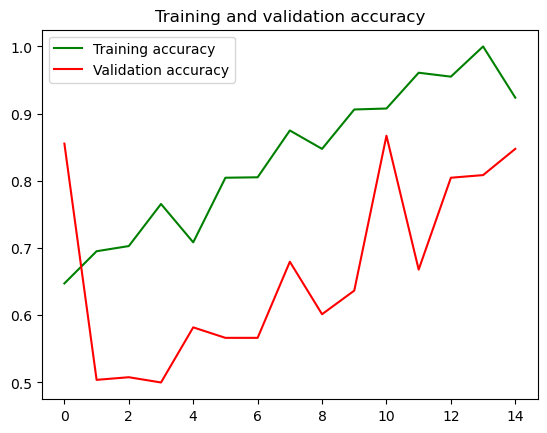

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 이미지 분류 예측 

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
def image_predict(file_name):
    path = 'horse-or-human예측용이미지/' + file_name
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)   # 2차원 ndarray로 변환
    x = np.expand_dims(x, axis=0) # 3차원으로 변환
    images = np.vstack([x])       # 4차원으로 변환
    classes = model.predict(images, batch_size=10)
    # print(classes[0],end=' ')
    if classes[0] == 1.0:
        print(file_name ,': human')
    else:
        print(file_name ,': horse')
        
image_predict('말01.jpg')        
image_predict('말02.jpg') 
image_predict('기린.jpg')    
image_predict('말과사람.jpg')
image_predict('말과사람02.jpg')
image_predict('말과사람06.jpg')
image_predict('사람01.jpg')
image_predict('사람02.jpg')
image_predict('사람12.jpg')
image_predict('말타기게임하는사람.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
말01.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
말02.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
기린.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
말과사람.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
말과사람02.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
말과사람06.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
사람01.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
사람02.jpg : horse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
사람12.jpg : human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
말타기게임하는사람.jpg : human


In [ ]:
# ! dir/w "horse-or-human예측용이미지/"

In [19]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.999):
                print("\nReached 99.9% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                               rotation_range = 40,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                        batch_size = 20,
                                        class_mode = 'binary',
                                        target_size = (300, 300))
    

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                      batch_size  = 20,
                                      class_mode  = 'binary',
                                      target_size = (300, 300))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

# CPU버전:약 15분 소요 ,epochs=10  , GPU: 약 4분
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50,  # 1027/20
    # epochs = 100,
    epochs=10,
    validation_steps=12,  # 256/20
    verbose=1,
    callbacks=[callbacks])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 78400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      40,141,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,165,409 (153.22 MB)

 Trainable params: 40,165,409 (153.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.5404 - loss: 1.1325 - val_accuracy: 0.5625 - val_loss: 0.6439
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8000 - loss: 0.5464 - val_accuracy: 0.4375 - val_loss: 0.6905
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.6868 - loss: 0.6300 - val_accuracy: 0.6333 - val_loss: 0.5709
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6000 - loss: 0.6644 - val_accuracy: 0.5000 - val_loss: 0.9812
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.7878 - loss: 0.4605 - val_accuracy: 0.5208 - val_loss: 2.5272
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8255 - loss: 0.3874 - val_accuracy: 0.7500 - val_loss: 1.1735
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.7915 - loss: 0.4704 - val_accuracy: 0.5458 - val_loss: 2.9233
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8000 - loss: 0.4398 - val_accuracy: 0.3125

In [22]:
# epochs를 100으로 수정하여 학습 시켜 볼것